# Классификация комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:**   
Построить модель для классифиции комментариев на позитивные и негативные со значением метрики качества *F1* не меньше 0.75

**Объект исследования:**   
Набор данных с разметкой о токсичности правок. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-и-знакомство-с-данными" data-toc-modified-id="Загрузка-и-знакомство-с-данными-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка и знакомство с данными</a></span><ul class="toc-item"><li><span><a href="#сокращение-выборки" data-toc-modified-id="сокращение-выборки-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>сокращение выборки</a></span></li></ul></li><li><span><a href="#Предобработка-текста" data-toc-modified-id="Предобработка-текста-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Предобработка текста</a></span></li><li><span><a href="#Деление-на-выборки" data-toc-modified-id="Деление-на-выборки-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Деление на выборки</a></span></li><li><span><a href="#Векторное-представление" data-toc-modified-id="Векторное-представление-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Векторное представление</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#LinearSVC" data-toc-modified-id="LinearSVC-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LinearSVC</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>SGDClassifier</a></span><ul class="toc-item"><li><span><a href="#Градиентный-бустинг-CatBoost" data-toc-modified-id="Градиентный-бустинг-CatBoost-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Градиентный бустинг CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Итоги</a></span></li></ul></div>

## Подготовка
### Импорт библиотек

In [1]:
# # установка библиотеки catboost
# !pip install catboost
# conda install spacy
# !spacy download en_core_web_sm

In [1]:
# импорт необходимых библиотек
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# отлеживание прогресса
from tqdm import tqdm
tqdm.pandas() # для работы progress_apply в пандас

# токенизация
from nltk.tokenize import word_tokenize

# лемматизация
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import spacy

# словарь стоп-слов
from nltk.corpus import stopwords
nltk.download('stopwords')

# векторизация текста
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# деление на выборки
from sklearn.model_selection import train_test_split

# метрика качества
from sklearn.metrics import f1_score, make_scorer, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


# подбор гипрепараметров
from sklearn.model_selection import RandomizedSearchCV, cross_validate, StratifiedKFold

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV

#   pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# линейные модели
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC

# модель градиентный бустинг из библиотеки catboost
import catboost as cb

# создание собственного трансформера из функции для пайплайн
from sklearn.base import BaseEstimator, TransformerMixin

# создание константной модели
from sklearn.dummy import DummyClassifier

# скрыть предупреждения
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thetonytime/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thetonytime/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/thetonytime/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thetonytime/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# зададим 3 знака после запятой для float при отображении табли
pd.options.display.float_format = '{:.3f}'.format

In [3]:
# зададим переменную с начальным состоянием генератора случайности для использования в моделях и рэндомсёрче
random_state = 42

### Загрузка и знакомство с данными

In [45]:
# вывод полного текста
pd.set_option("display.max_colwidth", 100)

# откроем файл с историчекими данными
# возможные пути расположения файла
server_path = '/datasets/toxic_comments.csv'  
local_path = 'toxic_comments.csv'
colab_path = '/content/toxic_comments.csv'

if os.path.exists(server_path):
    df_original = pd.read_csv(server_path, index_col=[0]) # первый столбец сделали индексом
elif os.path.exists(local_path):
    df_original = pd.read_csv(local_path, index_col=[0])
elif os.path.exists(colab_path):
    df_original = pd.read_csv(colab_path, index_col=[0])
else:
    'Неправильно указан путь к файлу'

In [46]:
# запишем датафрейм для работы, сохранив исходный, и посмотрим на содержимое
df = df_original.copy()
df

,text,toxic
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
...,...,...
159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in r...",0
159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61....,0
159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159449,And it looks like it was actually you who put on the speedy to have the first version deleted no...,0


В предоставленном датафрейме 159 292 объектов и 2 признака, включая целевой:
- `text` - текст комментария на английском языке
- `toxic` — целевой признак - токсичность комментария, где:
    - `1` - токсичный
    - `0` - нетоксичный

In [6]:
# посмотрим пропуски и типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [7]:
# проверим на явные дубликаты
f'Количество дубликатов: {df.duplicated().sum()}'

'Количество дубликатов: 0'

Дубликатов и пропусков нет. Типы данных подходящие.

Посмотрим на распределение целевого признака

In [8]:
f'Количество токсичных комментариев: {df["toxic"].sum()}, доля {df["toxic"].mean() * 100 :.2f}%'

'Количество токсичных комментариев: 16186, доля 10.16%'

Имеем дисбаланс классов - токсичных комментариев, которые нам нужно выявлять, всего 10%.

    
#### сокращение выборки
Сократим выборку для ускорения вычислительных операций (практически найдено, что 10% данных достаточно для достижения удовлетворительного качества модели).

In [47]:
# отделим 2% с соблюдением распределения целевого признака
df_useless, df_useful = train_test_split(df, 
                     random_state=random_state, 
                     test_size=0.1, 
                     stratify=df['toxic'])
# перезапишем рабочий датасет на сокращённый
df = df_useful
df.describe()

,toxic
count,15930.000
mean,0.102
std,0.302
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


### Предобработка текста
Прежде чем перейти к векторному представлению слов и обучению проводём очистку и предобработку текста:
- Приведение текстов к нижнему регистру
- Очистка от символов - оставляем только буквы, текст ссылок заменяем на слово "сайт"
- Токенизация - разбиение на слова
- Лемматизация - приводение к начальной словарной форме
- Очистка от стоп-слов и ненужных символов

Для предобработки текста напишем собственные функции `clean_text` и `lemmatize_spacy`

In [10]:
# функция для очистки текста
def clean_text(text):
    # перевести текст в нижний регистр
    text = text.lower()
    
    # заменим ссылки на слово "сайт"
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'сайт', text) # код скопировали
    # обращение к пользователю заменяем на "пользователь"
    text = re.sub('@[^\s]+', 'пользователь', text)

    # оставляем только буквы
    text_only = re.sub(r'[^a-z]', ' ', text)

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english')) # Используем стоп-слова на английском языке
    cleaned_list = [word for word in text_only.split() if word not in stop_words]
    
    # Соединяем в текст 
    prepared_text = " ".join(cleaned_list)
    
    return prepared_text

In [11]:
# функция для лемматизации столбца с текстом
def lemmatize_spacy(text_col):
    nlp = spacy.load('en_core_web_sm')
    
    new_corpus = []

    for doc in tqdm(nlp.pipe(text_col, 
                             batch_size=64, 
                             n_process=-1, 
                             disable=["parser", "ner"]), # убрали лишние операции
                    total=len(text_col)):
        word_list = [tok.lemma_ for tok in doc]
        new_corpus.append(' '.join(word_list))
    return new_corpus


In [48]:
# очистка текста - применим функцию к каждому элементу столбца 
print('Очистка текста:')
df['prepared_text'] = df['text'].progress_apply(lambda x: clean_text(x))
# лемматизация текста - применим функцию ко всему столбцу
print('Лемматизация текста:')
df['prepared_text'] = lemmatize_spacy(df['prepared_text'])

df.head()

Очистка текста:


100%|██████████| 15930/15930 [00:04<00:00, 3266.60it/s]


Лемматизация текста:


100%|██████████| 15930/15930 [01:38<00:00, 162.41it/s]


,text,toxic,prepared_text
151009,"""\n Ok, an seems pretty clear by now what editor is responsible here. Amalthea """,0,ok seem pretty clear editor responsible amalthea
30615,Proposal for standard infobox for History of [country] templates\n\nHi there! You're a member of...,0,proposal standard infobox history country template hi member wikiproject history inform proposal...
35343,"""\n\n Hi, Pompous Ass! ;) \n\nI know you think you're some kind of poker authority on Wikipedia...",1,hi pompous ass know think kind poker authority wikipedia somehow perogative give imperial final ...
156814,I am under attack! \n\nYou guys are censoring any opinion that you do not agree with! And you ha...,0,attack guy censoring opinion agree respond proof point view
97214,Why include Peter and Emerich?==\n\nPeter the Hermit and Emerich's respective endeavours really ...,0,include peter emerich peter hermit emerich respective endeavour really nothing actual first crus...


In [13]:
#  второй способ лемматизации, выполняется дольше
# # вспомогательная функция для лемматизации
# # функция для добавления pos-тега (части речи) для работы nltk-лемматизатора 
# def get_wordnet_pos(word):
#     tag = nltk.pos_tag([word])[0][1][0].upper() # определяет pos-тег слова, берёт из него часть речи (вторую букву)
#     # словарь для присваивания части речи
#     tag_dict = {"J": wordnet.ADJ, 
#                 "N": wordnet.NOUN,
#                 "V": wordnet.VERB,
#                 "R": wordnet.ADV}
#     # возвращает из словаря обозначение нужной части речи по вычисленному тегу, при отсутствии тега, вернёт существительное
#     return tag_dict.get(tag, wordnet.NOUN) 

# # функция для очистки текста
# def preprocess_text(text):
#     # перевести текст в нижний регистр
#     text = text.lower()
    
#     # заменим ссылки на слово "сайт"
#     #text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'сайт', text) # код скопировали
#     # обращение к пользователю заменяем на "пользователь"
#     #text = re.sub('@[^\s]+', 'пользователь', text)

#     # оставляем только буквы
#     text_only = re.sub(r'[^a-z]', ' ', text)
    
#     # Токенизация текста для дальнейшей лемматизации
#     tokenized = nltk.word_tokenize(text_only)
    
    
#     # Создаем экземпляр лемматизатора
#     lemmatizer = WordNetLemmatizer()
#     # Лемматизация с соответствующим pos-тегом
#     lemm_list = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokenized]
    
   
#     Удаление стоп-слов
#     stop_words = set(stopwords.words('english')) # Используем стоп-слова на английском языке
#     cleaned_list = [word for word in lemm_list if word not in stop_words]
    
#     # Соединяем в текст 
#     prepared_text = " ".join(cleaned_list)
    
#     return prepared_text

### Деление на выборки
Перед векторизацией разделим выборки, чтобы избежать утечки данных

In [49]:
# целевой признак
y = df['toxic']
X = df['prepared_text']

# разделим датасет на обучающуи тестовую выборки 85/15, сохранив распределение целевого признака
X_train, X_test, y_train, y_test  = train_test_split(X, y,
                                                     random_state=random_state, 
                                                     test_size=0.15, 
                                                     stratify=y)

In [50]:
# проверим распределение целевого признака в выборках и их размеры
print(f"""Обучающая выборка: {y_train.shape[0]}, {y_train.mean():.3f}, 
Тестовая выборка: {y_test.shape[0]}, {y_test.mean():.3f}""")

Обучающая выборка: 13540, 0.102, 
Тестовая выборка: 2390, 0.102


### Векторное представление
Подготовленный текст передадим алгоритмам, которые переведут их в векторные представления. Для этого модель обращается к составленному заранее словарю токенов. На выходе для каждого текста образуются вектор заданной длины.


В рамках задачи попробуем подобрать наиболее эффективное векторное представление. Рассмотрим варианты:
1. Bag of words, Bag of words с биграммами и триграммами, TF-IDF, TF-IFD c биграммами и триграммами

Подберём лучший вариан обучением логистической регрессии

In [51]:
# константное разбиение на фолды для кросс-валидации с соблюдением распределения целевого признака
kf = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)

# пайплайн для векторизации TfidfVectorizer
pipeline_vec = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('logreg', LogisticRegression(random_state=random_state))
])

# подбираем параметры для векторизации
parameters = {
    'vectorizer': [ TfidfVectorizer()],
#     'vectorizer__max_df': np.linspace(0.2, 0.98),
    'vectorizer__ngram_range':  [(1, 1), (1, 2), (1, 3)],
    'logreg__C': ['balanced', None],
    'logreg__C': range(1, 10),
    'logreg__max_iter': [300]
                }

rand_search_vec = RandomizedSearchCV(pipeline_vec, parameters, cv=kf, n_iter=10, n_jobs=-1, scoring='f1', verbose=1,
                                      random_state=random_state)
rand_search_vec.fit(X_train, y_train)

# Вывод наилучших параметров и оценки
print("Best parameters:", rand_search_vec.best_params_)
print("Best score:", rand_search_vec.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'vectorizer__ngram_range': (1, 1), 'vectorizer': TfidfVectorizer(), 'logreg__max_iter': 300, 'logreg__C': 9}
Best score: 0.6887688884393028



Лучше всего в комбинации с логистической регрессией отработали мешок слов и TF-IDF без биграмм. 
Для дальнейшей работы выберем векторизацию TF-IDF, так как этот алгоритм ещё учитывает важность слов в контексте всего корпуса текстов.

## Обучение
Перед нами стоит задача бинарной классификации, метод обучения с учителем. Модели будут обучаться на векторных представлениях текстов.
Наша модель должна прогнозировать эмоциональную окраску текста — 0 («положительная») или 1 («отрицательная»). 

Для оценки качества и выбора лучшей модели будем использовать F1-меру. 

Для поиска лучшего решения протестируем:
- LogisticRegression
- LinearSVC
- SGDClassifier
- Градиентный бустинг CatBoost

Для линейных моделей сделаем подбор гиперпараметров с помощью RandomizedSearchCV.  
Гоадиентный бустинг обучим без подбора гиперпараметров на векторизированном тексте.

Чтобы устранить влияние дисбаланса класса при обучении попробуем настроить гиперпараметр `class_weight`

In [52]:
# функция для подбора ГП  и рассчёта метрики на кросс-валидации
def rs_func(pipe, params):
    # кросс-валидация будет делить на 5 частей, оцениваем по f1
    rand_search = RandomizedSearchCV(pipe, params, cv=kf, n_jobs=-1, scoring='f1', verbose=1, 
                                      error_score=0, random_state=random_state, n_iter=10)
    # обучаем на тренировочной выборке
    rand_search.fit(X_train, y_train)
    # зафиксируем лучшую модель и метрику в переменной
    f1, model_rs = rand_search.best_score_, rand_search
    return f1, model_rs

### Логистическая регрессия

In [53]:
# пайплайн для логистической регрессии
pipeline_logr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logr', LogisticRegression(random_state=random_state))
])

# перебор параметров для модели
params_logr = {'logr__class_weight' : [None, 'balanced'],
                'logr__max_iter': [200, 300, 500, 800],
                'logr__C': np.arange(.0, 15, 0.25),
                'logr__penalty' : ['l1', 'l2', 'elasticnet']}


f1_logr, model_logr_rs = rs_func(pipeline_logr, params_logr)
f1_logr, model_logr_rs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


(0.7309505321200525,
 {'logr__penalty': 'l2',
  'logr__max_iter': 800,
  'logr__class_weight': 'balanced',
  'logr__C': 13.25})

### LinearSVC 
Линейный метод опорных векторов с поддержкой классификации, стремится найти оптимальную разделяющую гиперплоскость между классами.

In [54]:

# пайплайн для LinearSVC
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', LinearSVC(random_state=random_state))
])

# перебор параметров для модели
params_svc = {'svc__class_weight' : [None, 'balanced'],
                'svc__loss': ['hinge', 'squared_hinge'],
                'svc__C': np.arange(0.25, 3.01, 0.25),
                'svc__penalty' : ['l1', 'l2'],
                'svc__dual' : [True, False]}


f1_svc, model_svc_rs = rs_func(pipeline_svc, params_svc)

f1_svc, model_svc_rs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


(0.7269131226680161,
 {'svc__penalty': 'l2',
  'svc__loss': 'squared_hinge',
  'svc__dual': False,
  'svc__class_weight': 'balanced',
  'svc__C': 0.25})

### SGDClassifier
Модель SGDClassifier - линейная модель классификации, обучаемая с использованием стохастического градиентного спуска. Она отличается от классического LinearSVC тем, что обновление параметров модели происходит на каждом примере обучающего набора, в отличие от обновления на каждой эпохе.

In [55]:

# пайплайн для LinearSVC
pipeline_sgd = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd', SGDClassifier(random_state=random_state))
])

# перебор параметров для модели
params_sgd = {'sgd__class_weight' : [None, 'balanced'],
                'sgd__loss': ['hinge', 'log', 'modified_huber'],
                'sgd__alpha': [0.0001, 0.0001, 0.001, 0.1, 1],
                'sgd__penalty' : ['l1', 'l2', 'elasticnet']}


f1_sgd, model_sgd_rs = rs_func(pipeline_sgd, params_sgd)
f1_sgd, model_sgd_rs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/thetonytime/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/thetonytime/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/thetonytime/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/Users/thetonytime/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was dep

(0.7185746473480423,
 {'sgd__penalty': 'l2',
  'sgd__loss': 'hinge',
  'sgd__class_weight': 'balanced',
  'sgd__alpha': 0.0001})

#### Градиентный бустинг CatBoost
Градиентный бустинг CatBoost обучим без подбора гиперпараметров на вектоизированной тренировочной выборке TF-IDF


In [21]:

# пайплайн для CatBoostClassifier
pipeline_gbc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('gbc', cb.CatBoostClassifier(random_state=random_state, silent=True))
])

# перебор параметров для модели
params_gbc = {'gbc__auto_class_weights' : ['Balanced'],
                'gbc__iterations': [200]}


f1_gbc, model_gbc_rs = rs_func(pipeline_gbc, params_gbc)
f1_gbc, model_gbc_rs.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


(0.7370074807723123,
 {'gbc__iterations': 200, 'gbc__auto_class_weights': 'Balanced'})

Результаты испытаний всех моделей

In [30]:
results_table = pd.DataFrame([ f1_logr, f1_svc, f1_sgd, f1_gbc],
                            columns=[ 'F1'],
                            index=['LogisticRegression', 'LinearSVC', 'SGDClassifier', 'CatBoost'])
results_table

,F1
LogisticRegression,0.745
LinearSVC,0.746
SGDClassifier,0.711
CatBoost,0.737


Лучший результат на кросс-валидации показала модель LogisticRegression.

### Тестирование модели
Протестируем выбранную модель на ранее отложенной тестовой выборке.  


In [56]:
# предсказания с помощью пайплайна с логистической регрессией
y_pred = model_logr_rs.predict(X_test)

# применим к тестовой выборке, добавим в сводую таблицу результат
results_table.loc['LogisticRegression_TEST'] = f1_score(y_test, y_pred)
results_table

,F1
LogisticRegression,0.745
LinearSVC,0.746
SGDClassifier,0.711
CatBoost,0.737
LogisticRegression_TEST,0.753


На новых данных модель показывает равнозначный результат. Посмотрим подробнее на матрице ошибок

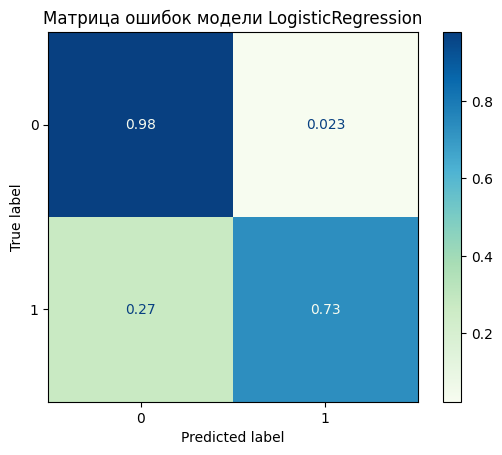

In [58]:
# построим Confusion Matrix, отображение в долях
cm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='GnBu')
plt.title('Матрица ошибок модели LogisticRegression')
plt.show()

Модель ошибается в предсказании положительного класса (токсичный комментарий) в 27% и более точна в предсказании отрицательного (нетоксичный) 98%.

Тест на адекватность - проверим, предсказывает ли наша модель лучше, чем константная.  
Воспроизведём модель, которая всегда предсказывает, что комментарий токсичный.

In [57]:
# воспроизведём случай, что модель всегда предсказывает 1
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

results_table.loc['Dummy'] = f1_score(y_test, dummy.predict(X_test))
results_table.style.set_precision(2)

,F1
LogisticRegression,0.75
LinearSVC,0.75
SGDClassifier,0.71
CatBoost,0.74
LogisticRegression_TEST,0.75
Dummy,0.18


Выбранная модель LogisticRegression с подобранным набором гиперпараметров прошла финальное испытание:
- F1-мера на тестовой выборке равно 0.75
- Модель предсказывает лучше, чем случайная

___

## Итоги
Перед была поставлена задача прогнозирования эмоциональной окраски текста комментария — 0 («положительная») или 1 («отрицательная») с целью отправки их на модерацию.

Для исследования предоставлен набор данных, содержащий 159 292 текстов с разметкой о токсичности. В распределении целевого признака выявлен дисбаланс классов: всего 10% токсичных комментарив. 

Для обучения моделей текст предварительно был обработан:
- очищен от символов, цифр, стоп-слов
- лемматизарован
- приведён к векторному представлению слов при помощи алгоритма TF-IDF - выбран один из 4-х рассмотренных вариантов

Для поиска лучшего решения протестированы 4 модели: 3 линейные - LogisticRegression, LinearSVC, SGDClassifier, и градиентный бустинг CatBoost. Для устранения влияния дисбаланса классов при обучении использован гиперпараметр class_weight='balanced'.

Для оценки качества использована метрика F1-мера. Заданное условие: F1-мера ≥ 0.75 на тестовой выборке.

В результате исследования для решения задачи выбрана комбинация с моделью **TF-IDF + LogisticRegression** с подобранным набором гиперпараметров. Заданное условие качества модели достигнуто - F1-мера = 0.75.
